In [1]:
try: 
    import seaborn as sns
except:
    %pip install seaborn
    import seaborn as sns
try:
    import pymc as pm # For MCMC
except:
    %pip install pymc
    import pymc as pm
try:
    import arviz as az # For MCMC package
except:
    %pip install arviz
    import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
try:
    import corner
except:
    %pip install corner
    import corner

print(pm.__version__)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.15.0


## Importing data

In [2]:
import pandas as pd

file_path = 'datasets/Donor1_CD4_Genes.csv'

df1 = pd.read_csv(file_path)


In [3]:
def dfg(a,b):
    file_path = 'datasets/Donor%d_CD%d_Genes.csv' %(a,b)
    all_df = pd.read_csv(file_path)
    file_path = 'datasets/mt_genes_metadata.csv'
    dfmeta = pd.read_csv(file_path)
    protein_coding_genes = dfmeta[dfmeta['gene_type'] == 'protein_coding']
    protein_names = protein_coding_genes['gene_name'].tolist()
    df2 = pd.DataFrame([all_df[i] for i in protein_names]).T
    return df2

   

### I only need 13 proteins, df2 

In [4]:
file_path = 'datasets/mt_genes_metadata.csv'

dfmeta = pd.read_csv(file_path)


protein_coding_genes = dfmeta[dfmeta['gene_type'] == 'protein_coding']
protein_names = protein_coding_genes['gene_name'].tolist()
tRNA_coding_genes = dfmeta[dfmeta['gene_type']=='Mt_tRNA']
tRNA_names = tRNA_coding_genes['gene_name'].tolist()
rRNA_coding_genes = dfmeta[dfmeta['gene_type']=='Mt_rRNA']
rRNA_names = rRNA_coding_genes['gene_name'].tolist()

umi = df1["non-MT"]
df2 = pd.DataFrame([df1[i] for i in protein_names]).T

print(df2.head)

<bound method NDFrame.head of       MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP8  MT-ATP6  MT-CO3  MT-ND3  \
0         12       3      23      53       34        3      38       6   
1          8       4      24      35       10        2      34       3   
2          7       2      16      30        8        1      19       6   
3          3       2      25      23       14        5      23       2   
4          6       3       6      26       14        1      11       4   
...      ...     ...     ...     ...      ...      ...     ...     ...   
2883       4       0      20      15       11        3      11       2   
2884       2       5      13      28       12        2      18       6   
2885       5       0      10      22       13        1      14       4   
2886       6      12      36      45       19        2      40       5   
2887       7       1       9      24       11        0      22       1   

      MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
0          20       5       7    

### ***A suggestion about the dataframe: genes are columns and cells are rows, rest of my code will strictly follow this way***

---


## Next step, normalisation

### a function: normiz
normally we would expect the normalization to be \

 row(cells) / umi correponding * some number \
 \
I *prefer* taking the some number to be norm of the umi \
so an optional parameter somenumber is there. 

In [5]:
def normiz(df,umi,somenumber = np.linalg.norm(umi)):
    df1 = df.T
    norm = np.linalg.norm(umi)
    print(norm)
    umi1 = umi/somenumber
    for i in range(len(umi1)):
        df1[i] = df1[i] / umi1[i]
    return df1.T

In [6]:
normiz(df2,umi)

250070.22420512204


,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,2400.674152,600.168538,4601.292125,10602.977506,6801.910098,600.168538,7602.134816,1200.337076,4001.123587,1000.280897,1400.393256,1400.393256,4001.123587
1,837.405523,418.702761,2512.216568,3663.649162,1046.756903,209.351381,3558.973471,314.027071,1570.135355,732.729832,628.054142,104.675690,1779.486736
2,651.952167,186.272048,1490.176383,2794.080717,745.088191,93.136024,1769.584454,558.816143,1862.720478,279.408072,651.952167,0.000000,1397.040359
3,305.460372,203.640248,2545.503097,2341.862849,1425.481734,509.100619,2341.862849,203.640248,1323.661610,407.280495,610.920743,305.460372,1425.481734
4,369.561908,184.780954,369.561908,1601.434933,862.311118,61.593651,677.530164,246.374605,862.311118,0.000000,123.187303,0.000000,431.155559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,323.088145,0.000000,1615.440725,1211.580544,888.492399,242.316109,888.492399,161.544072,403.860181,161.544072,242.316109,0.000000,323.088145
2884,171.046665,427.616662,1111.803322,2394.653310,1026.279990,171.046665,1539.419985,513.139995,1197.326655,171.046665,171.046665,85.523332,684.186660
2885,278.103007,0.000000,556.206015,1223.653232,723.067819,55.620601,778.688421,222.482406,333.723609,389.344210,278.103007,55.620601,1112.412029
2886,282.671693,565.343386,1696.030157,2120.037696,895.127027,94.223898,1884.477952,235.559744,942.238976,376.895590,329.783642,0.000000,1743.142105


### Function of plotting the mean-var scatter

In [7]:
def meanvarplot(seq1):
    seq = seq1.T
    list_mean = [np.mean(seq.iloc[i]) for i in range(13)]
    list_var = [np.var(seq.iloc[i]) for i in range(13)]
    x = np.linspace(0,min(max(list_mean),max(list_var)),num = 1000)
    plt.plot(x,x)
    plt.scatter(list_mean, list_var)
    plt.show()
    print(list_var)
    print(list_mean)

250070.22420512204


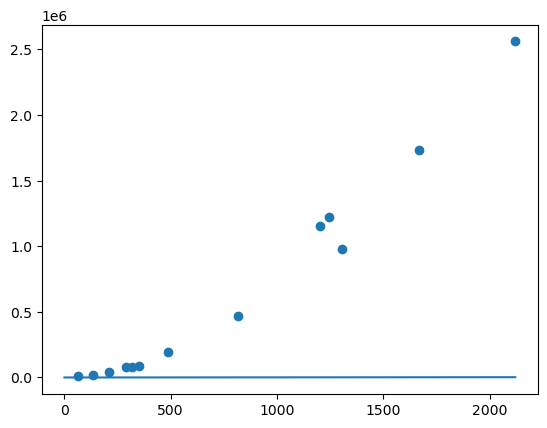

[197516.81753114882, 82218.14966938939, 1221408.3269125617, 2560068.8128141835, 1152600.1028193296, 20077.98207445609, 1732083.4918172525, 89939.2350333792, 471527.07319675357, 42848.96457824826, 81226.92123084699, 11699.042495722777, 977378.9237283919]
[488.7334062974924, 289.5180470360056, 1244.2397266879382, 2119.8521536797325, 1202.526820278621, 132.84329662468247, 1665.6717197338446, 349.19131182141916, 814.0877795718288, 208.09735318701775, 317.4216246808961, 65.28457339684515, 1302.940113074823]


In [8]:
meanvarplot(normiz(df2,umi))

In [9]:
# y = [39405502178.874176, 14270050297.713615, 215355647899.84335, 539331414712.78564, 239734538779.75415, 2747234578.422771, 394348531643.9634, 14472016525.325699, 91730867514.77098, 5754079977.802822, 12961089066.25124, 1596013212.4993975, 204012584253.58527]
# x = [47630.013913849674, 29529.369527593317, 126661.54897436462, 215709.66710226206, 118022.10441414938, 12465.609550242913, 165462.9110493637, 34138.95923555267, 82932.81850558078, 20593.452077464488, 30539.072451652246, 6644.006650370145, 129042.84368275816]
# plt.scatter(np.log(x),np.log(y))

250070.22420512204


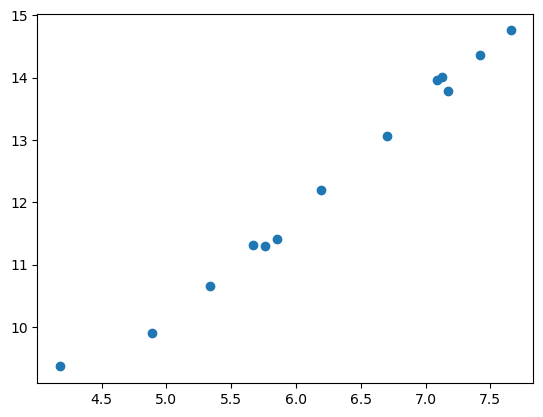

In [10]:
df3 = normiz(df2,umi)
df4 = df3.T
tri_mean = [np.mean(df4.iloc[i]) for i in range(13)]
tri_var = [np.var(df4.iloc[i]) for i in range(13)]
x = tri_mean
y = tri_var
plt.scatter(np.log(x),np.log(y))

In [11]:
def linfitplot(x,y):
    linear_model = pm.Model()
# Define the PyMC model
    with linear_model:
        # Priors for unknown parameters
        a_prior = pm.Normal('a', mu=0, sigma=10)
        b_prior = pm.Normal('b', mu=0, sigma=10)
        sigma_prior = pm.HalfNormal('sigma', sigma=2)

        # Expected value of outcome
        mu = a_prior * x + b_prior

        # Likelihood (sampling distribution) of observations
        vals = pm.Normal('vals', mu=mu, sigma=sigma_prior, observed=y)
        
        step = pm.Slice()
        tracel = pm.sample(1000, step=step, return_inferencedata=True)
        ppc_samples = pm.sample_posterior_predictive(tracel)
    
    ppc_vals = np.asarray(ppc_samples["posterior_predictive"].vals)
    
    for y_i in ppc_vals[0]:
        plt.plot(x,y_i,alpha=0.1,color="pink")
    
    plt.plot(x,y,"ko",label="Data")
    plt.legend()
    plt.xlabel("x")
    plt.xlabel("y")

In [12]:
linfitplot(np.log(x),np.log(y))


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [a]
>Slice: [b]
>Slice: [sigma]


Output()

log(mean) = a * log(varience) + b + Error \
?


## New scaling 

In [ ]:
df2

,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,12,3,23,53,34,3,38,6,20,5,7,7,20
1,8,4,24,35,10,2,34,3,15,7,6,1,17
2,7,2,16,30,8,1,19,6,20,3,7,0,15
3,3,2,25,23,14,5,23,2,13,4,6,3,14
4,6,3,6,26,14,1,11,4,14,0,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,4,0,20,15,11,3,11,2,5,2,3,0,4
2884,2,5,13,28,12,2,18,6,14,2,2,1,8
2885,5,0,10,22,13,1,14,4,6,7,5,1,20
2886,6,12,36,45,19,2,40,5,20,8,7,0,37


In [ ]:
def normiz_2(df,s_n = 1000):
    df1 = df
    listfinal = [sum(df.iloc[i]) for i in range(len(df))]
    for i in range(len(df)):
        df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
    return df1

In [ ]:
normiz_2(df2)

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.948051948051955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.987012987012989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.56709956709956' has dtype incompatible with int64, pleas

,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,51.948052,12.987013,99.567100,229.437229,147.186147,12.987013,164.502165,25.974026,86.580087,21.645022,30.303030,30.303030,86.580087
1,48.192771,24.096386,144.578313,210.843373,60.240964,12.048193,204.819277,18.072289,90.361446,42.168675,36.144578,6.024096,102.409639
2,52.238806,14.925373,119.402985,223.880597,59.701493,7.462687,141.791045,44.776119,149.253731,22.388060,52.238806,0.000000,111.940299
3,21.897810,14.598540,182.481752,167.883212,102.189781,36.496350,167.883212,14.598540,94.890511,29.197080,43.795620,21.897810,102.189781
4,63.829787,31.914894,63.829787,276.595745,148.936170,10.638298,117.021277,42.553191,148.936170,0.000000,21.276596,0.000000,74.468085
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,50.000000,0.000000,250.000000,187.500000,137.500000,37.500000,137.500000,25.000000,62.500000,25.000000,37.500000,0.000000,50.000000
2884,17.699115,44.247788,115.044248,247.787611,106.194690,17.699115,159.292035,53.097345,123.893805,17.699115,17.699115,8.849558,70.796460
2885,46.296296,0.000000,92.592593,203.703704,120.370370,9.259259,129.629630,37.037037,55.555556,64.814815,46.296296,9.259259,185.185185
2886,25.316456,50.632911,151.898734,189.873418,80.168776,8.438819,168.776371,21.097046,84.388186,33.755274,29.535865,0.000000,156.118143


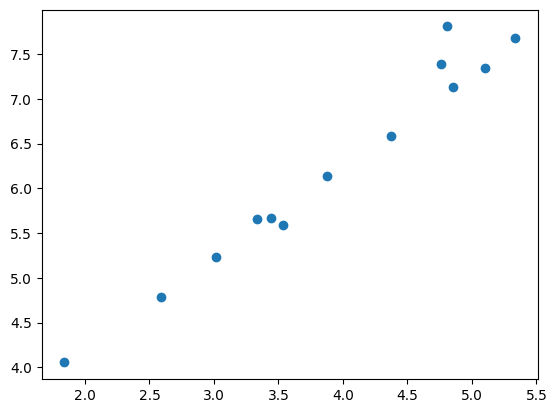

In [ ]:
df_final = normiz_2(df2).T
gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
log_gene_mean = np.log(gene_mean)
log_gene_var = np.log(gene_var)
plt.scatter(log_gene_mean,log_gene_var)

In [ ]:
def g_log(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    return log_gene_mean, log_gene_var
    

In [ ]:
def log_gene_plot(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    plt.scatter(log_gene_mean,log_gene_var)

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.948051948051955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.987012987012989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.56709956709956' has dtype incompatible with int64, pleas

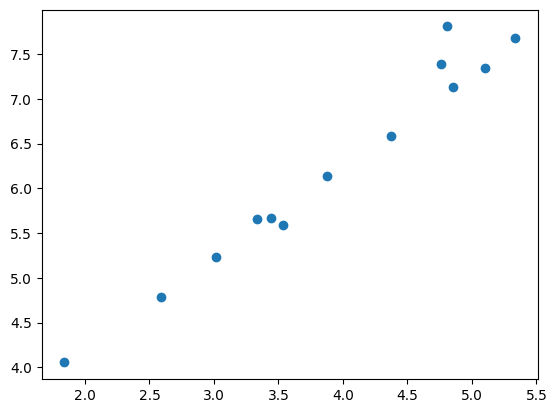

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.242424242424242' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.42424242424243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '133.33333333333334' has dtype incompatible with int64, pleas

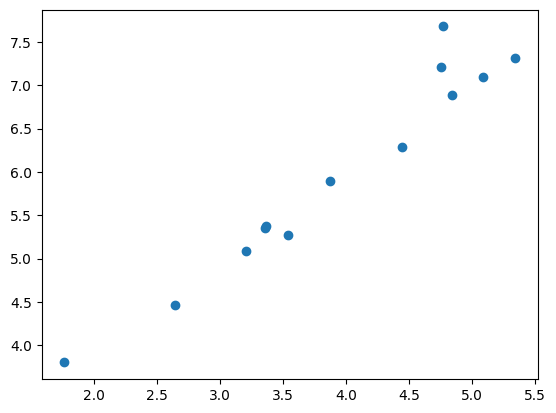

In [ ]:
log_gene_plot(normiz_2(dfg(1,4)))
plt.show()
log_gene_plot(normiz_2(dfg(1,8)))
plt.show()

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.81553398058252' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.398058252427184' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.6504854368932' has dtype incompatible with int64, please

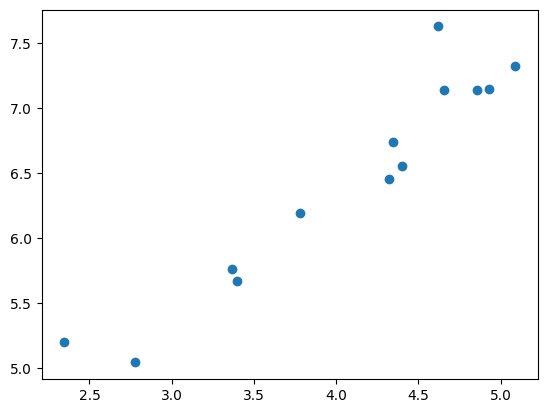

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '78.34101382488478' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.433179723502302' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '188.9400921658986' has dtype incompatible with int64, please

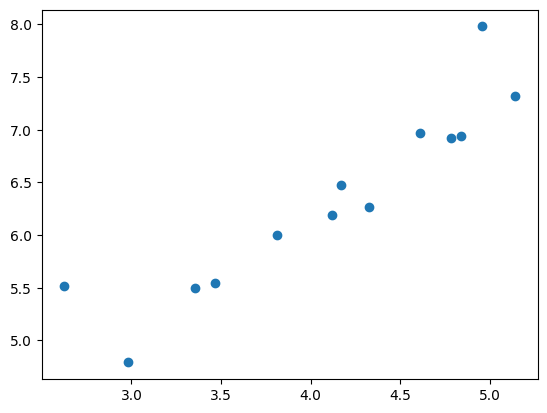

In [ ]:
log_gene_plot(normiz_2(dfg(2,4)))
plt.show()
log_gene_plot(normiz_2(dfg(2,8)))
plt.show()

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.948051948051955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.987012987012989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.56709956709956' has dtype incompatible with int64, pleas

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [vals]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

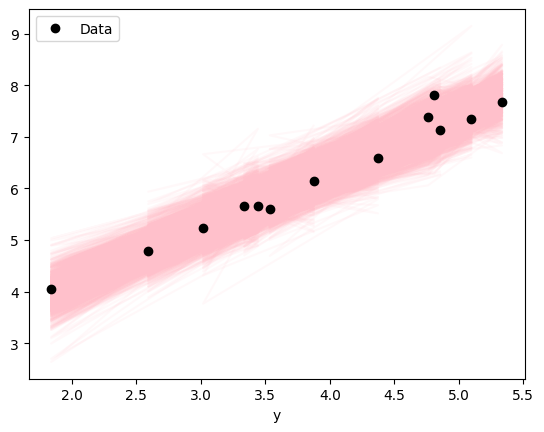

In [ ]:
linfitplot(g_log(normiz_2(dfg(1,4)))[0],g_log(normiz_2(dfg(1,4)))[1])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def lse(a,b):
    x = g_log(normiz_2(dfg(a,b)))[0]
    y = g_log(normiz_2(dfg(a,b)))[1]

    X = np.vstack([np.ones(len(x)), x]).T
    # Compute the least squares estimates using the normal equation
    # theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    # Extract the parameters
    a, b = theta
    print(f"Estimated parameters: a = {a}, b = {b}")

    # Predicted values using the fitted model
    y_pred = a + b * x

    # Calculate R-squared (R^2)
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"R-squared (R^2) value: {r_squared}")

    # Plot the observed data and the fitted line
    plt.scatter(x, y, label='Observed data')
    plt.plot(x, y_pred, color='red', label='Fitted line')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Least Squares Estimation')
    plt.legend()
    plt.show()


/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.948051948051955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.987012987012989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.56709956709956' has dtype incompatible with int64, pleas

Estimated parameters: a = 1.9340102220340807, b = 1.099356698931799
R-squared (R^2) value: 0.9670751161979678


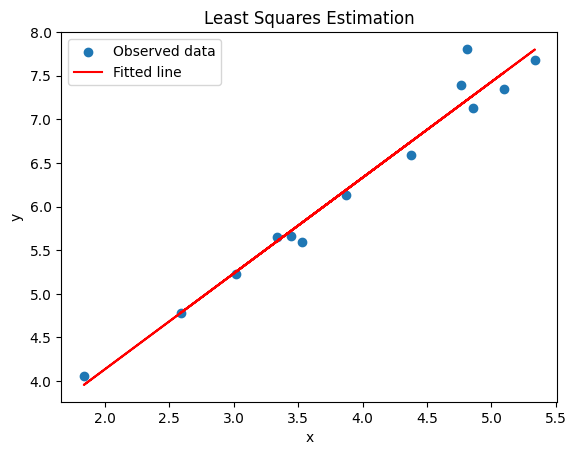

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.242424242424242' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.42424242424243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '133.33333333333334' has dtype incompatible with int64, pleas

Estimated parameters: a = 1.6414409105514114, b = 1.1061489870280314
R-squared (R^2) value: 0.9435186749758206


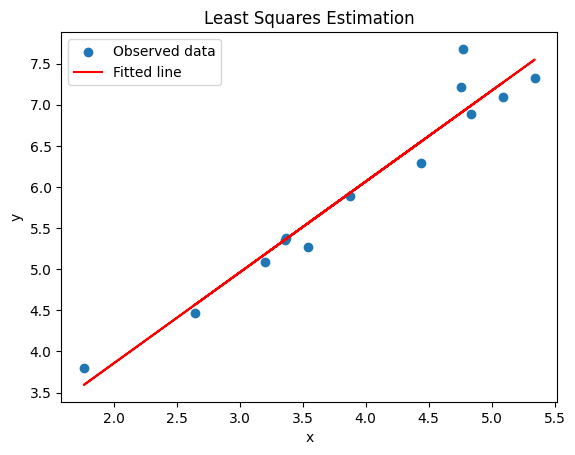

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.81553398058252' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.398058252427184' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.6504854368932' has dtype incompatible with int64, please

Estimated parameters: a = 2.7156409428469366, b = 0.9203798659612583
R-squared (R^2) value: 0.9083683585261985


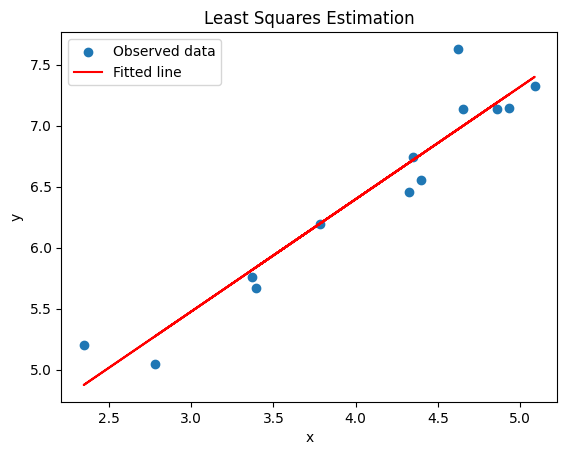

/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '78.34101382488478' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.433179723502302' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
/var/folders/c1/dwx649nn3230kr15mzg_vhvc0000gn/T/ipykernel_19264/3247431560.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '188.9400921658986' has dtype incompatible with int64, please

Estimated parameters: a = 2.1693370346252805, b = 1.0196174509223592
R-squared (R^2) value: 0.847941746380415


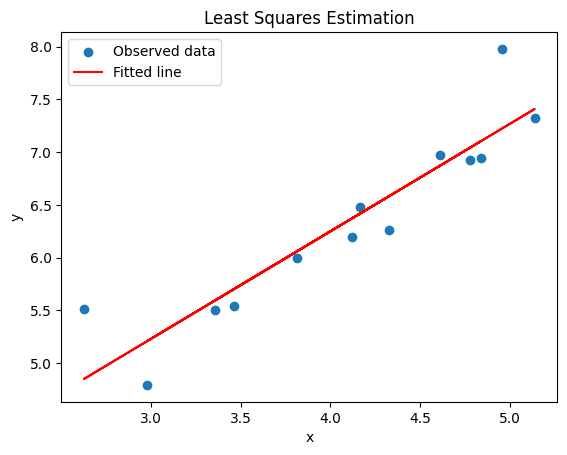

In [ ]:
lse(1,4)
lse(1,8)
lse(2,4)
lse(2,8)